In [ ]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers==2.8.0 -q

     |████████████████████████████████| 573kB 13.4MB/s 
     |████████████████████████████████| 890kB 43.4MB/s 
     |████████████████████████████████| 3.7MB 52.4MB/s 
     |████████████████████████████████| 1.1MB 33.9MB/s 
     |████████████████████████████████| 133kB 61.2MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
     |████████████████████████████████| 6.9MB 48.1MB/s 
ERROR: botocore 1.19.26 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
from transformers import *
import torch
from torch.utils.data import TensorDataset
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, SequentialSampler
from sklearn.svm import SVC
from sklearn.metrics import classification_report 

MAX_LEN = 128
BATCH_SIZE = 8

def metaclassifier_experiment(
    train_data_path,
    test_data_path,
    models_paths,
    dropnas=True):
  
  def tensor_dataset(sentences, labels, tokenizer):
    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
                            sent,                     
                            add_special_tokens = True,
                            max_length = MAX_LEN,
                            pad_to_max_length = True,
                            return_attention_mask = True,
                            return_tensors = 'pt',     # Return pytorch tensors.
                      )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    dataset = TensorDataset(input_ids, attention_masks, labels)
    return dataset

  def inverse_logit(x):
    return np.exp(x) / (1 + np.exp(x))

  def BERT_inference(model, dataloader):
    predicted_probs = []; true_labels = []
    model.to(device)
    for batch in dataloader:
      
      input_ids = batch[0].to(device)
      attention_masks = batch[1].to(device)
      labels = batch[2]
      
      with torch.no_grad():        
          outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                      
      logits = outputs[0]
      logits = logits.detach().cpu().numpy()
      predicted_probs.extend(inverse_logit(logits))
      
      labels = labels.numpy().flatten()
      true_labels.extend(labels)

    return np.array(predicted_probs), np.array(true_labels)

  
  if torch.cuda.is_available():    

      # Tell PyTorch to use the GPU.    
      device = torch.device("cuda")

      print('There are %d GPU(s) available.' % torch.cuda.device_count())

      print('We will use the GPU:', torch.cuda.get_device_name(0))

  else:
      print('No GPU available, using the CPU instead.')
      device = torch.device("cpu")

  device = torch.device("cuda")

  train_data = pd.read_csv(train_data_path, index_col=0)
  test_data = pd.read_csv(test_data_path, index_col=0)
  print("Loaded data ...")

  if dropnas:
      train_data = train_data.dropna()
      test_data = test_data.dropna()
      print("Dropped NAN's ...")

  tokenizers = []
  models = []
  for i, model_path in enumerate(models_paths):
    print("Tokenizer %s model ... " % i)
    tokenizer = BertTokenizer.from_pretrained(model_path)
    tokenizers.append(tokenizer)
    print("%s tokenizer loaded!" % i)
    
    print("Loading %s model ... " % i)
    model = BertForSequenceClassification.from_pretrained(model_path)
    models.append(model)
    print("%s model loaded!" % i)

  models_train_output = []
  for i, (model, tokenizer) in enumerate(zip(models, tokenizers)):
    print("%s data set preparation ..." % i)
    train_dataset = tensor_dataset(train_data.iloc[:,0].to_numpy(), train_data.iloc[:,1].to_numpy(), tokenizer)
    train_dataloader = DataLoader(train_dataset, sampler = SequentialSampler(train_dataset), batch_size = BATCH_SIZE)
    print("%s data set preparation end!" % i)

    print("%s model inference ..." % i)
    model_output, meta_train_labels = BERT_inference(model, train_dataloader)
    
    models_train_output.append(model_output)
    print("%s model inference end!" % i)
  
  meta_train_data = np.concatenate(models_train_output, axis=1)

  print("Training metaclassifier ...")
  meta_classifier = SVC(kernel='linear')
  meta_classifier.fit(meta_train_data, meta_train_labels)
  print("Metaclassifier trained!")

  models_test_output = []
  for i, (model, tokenizer) in enumerate(zip(models, tokenizers)):
    print("%s data set preparation ..." % i)
    test_dataset = tensor_dataset(test_data.iloc[:,0].to_numpy(), test_data.iloc[:,1].to_numpy(), tokenizer)
    test_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = BATCH_SIZE)
    print("%s data set preparation end!" % i)

    print("%s model inference ..." % i)
    model_output, meta_test_labels = BERT_inference(model, test_dataloader)
    models_test_output.append(model_output)
    print("%s model inference end!" % i)

  meta_test_data = np.concatenate(models_test_output, axis=1)

  print("Making final prediciton for tests ...")
  meta_test_prediction = meta_classifier.predict(meta_test_data)
  
  print(classification_report(y_true=meta_test_labels, y_pred=meta_test_prediction, zero_division=0))

In [ ]:
metaclassifier_experiment(
    train_data_path = '/content/drive/My Drive/dev_moto_data_preprocessed.csv',
    test_data_path = '/content/drive/My Drive/test_moto_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
metaclassifier_experiment(
    train_data_path = '/content/drive/My Drive/dev_treebank_data_preprocessed.csv',
    test_data_path = '/content/drive/My Drive/test_treebank_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
metaclassifier_experiment(
    train_data_path = '/content/drive/My Drive/dev_polemo_hotels_data_preprocessed.csv',
    test_data_path = '/content/drive/My Drive/test_polemo_hotels_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
metaclassifier_experiment(
    train_data_path = '/content/drive/My Drive/dev_polemo_medicine_data_preprocessed.csv',
    test_data_path = '/content/drive/My Drive/test_polemo_medicine_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
metaclassifier_experiment(
    train_data_path = '/content/drive/My Drive/dev_polemo_products_data_preprocessed.csv',
    test_data_path = '/content/drive/My Drive/test_polemo_products_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
metaclassifier_experiment(
    train_data_path = '/content/drive/My Drive/dev_polemo_reviews_data_preprocessed.csv',
    test_data_path = '/content/drive/My Drive/test_polemo_reviews_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
metaclassifier_experiment(
    train_data_path = '/content/drive/My Drive/dev_filmweb_data_preprocessed.csv',
    test_data_path = '/content/drive/My Drive/test_filmweb_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
import numpy as np
import pandas as pd
from transformers import *
import torch
from torch.utils.data import TensorDataset
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, SequentialSampler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report 

MAX_LEN = 128
BATCH_SIZE = 8

def xgboost_metaclassifier_experiment(
    train_data_path,
    test_data_path,
    models_paths,
    dropnas=True):
  
  def tensor_dataset(sentences, labels, tokenizer):
    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
                            sent,                     
                            add_special_tokens = True,
                            max_length = MAX_LEN,
                            pad_to_max_length = True,
                            return_attention_mask = True,
                            return_tensors = 'pt',     # Return pytorch tensors.
                      )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    dataset = TensorDataset(input_ids, attention_masks, labels)
    return dataset

  def inverse_logit(x):
    return np.exp(x) / (1 + np.exp(x))

  def BERT_inference(model, dataloader):
    predicted_probs = []; true_labels = []
    model.to(device)
    for batch in dataloader:
      
      input_ids = batch[0].to(device)
      attention_masks = batch[1].to(device)
      labels = batch[2]
      
      with torch.no_grad():        
          outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                      
      logits = outputs[0]
      logits = logits.detach().cpu().numpy()
      predicted_probs.extend(inverse_logit(logits))
      
      labels = labels.numpy().flatten()
      true_labels.extend(labels)

    return np.array(predicted_probs), np.array(true_labels)

  
  if torch.cuda.is_available():    

      # Tell PyTorch to use the GPU.    
      device = torch.device("cuda")

      print('There are %d GPU(s) available.' % torch.cuda.device_count())

      print('We will use the GPU:', torch.cuda.get_device_name(0))

  else:
      print('No GPU available, using the CPU instead.')
      device = torch.device("cpu")

  device = torch.device("cuda")

  train_data = pd.read_csv(train_data_path, index_col=0)
  test_data = pd.read_csv(test_data_path, index_col=0)
  print("Loaded data ...")

  if dropnas:
      train_data = train_data.dropna()
      test_data = test_data.dropna()
      print("Dropped NAN's ...")

  tokenizers = []
  models = []
  for i, model_path in enumerate(models_paths):
    print("Tokenizer %s model ... " % i)
    tokenizer = BertTokenizer.from_pretrained(model_path)
    tokenizers.append(tokenizer)
    print("%s tokenizer loaded!" % i)
    
    print("Loading %s model ... " % i)
    model = BertForSequenceClassification.from_pretrained(model_path)
    models.append(model)
    print("%s model loaded!" % i)

  models_train_output = []
  for i, (model, tokenizer) in enumerate(zip(models, tokenizers)):
    print("%s data set preparation ..." % i)
    train_dataset = tensor_dataset(train_data.iloc[:,0].to_numpy(), train_data.iloc[:,1].to_numpy(), tokenizer)
    train_dataloader = DataLoader(train_dataset, sampler = SequentialSampler(train_dataset), batch_size = BATCH_SIZE)
    print("%s data set preparation end!" % i)

    print("%s model inference ..." % i)
    model_output, meta_train_labels = BERT_inference(model, train_dataloader)
    
    models_train_output.append(model_output)
    print("%s model inference end!" % i)
  
  meta_train_data = np.concatenate(models_train_output, axis=1)

  print("Training metaclassifier ...")
  meta_classifier = XGBClassifier()
  meta_classifier.fit(meta_train_data, meta_train_labels)
  print("Metaclassifier trained!")

  models_test_output = []
  for i, (model, tokenizer) in enumerate(zip(models, tokenizers)):
    print("%s data set preparation ..." % i)
    test_dataset = tensor_dataset(test_data.iloc[:,0].to_numpy(), test_data.iloc[:,1].to_numpy(), tokenizer)
    test_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = BATCH_SIZE)
    print("%s data set preparation end!" % i)

    print("%s model inference ..." % i)
    model_output, meta_test_labels = BERT_inference(model, test_dataloader)
    models_test_output.append(model_output)
    print("%s model inference end!" % i)

  meta_test_data = np.concatenate(models_test_output, axis=1)

  print("Making final prediciton for tests ...")
  meta_test_prediction = meta_classifier.predict(meta_test_data)
  
  print(classification_report(y_true=meta_test_labels, y_pred=meta_test_prediction, zero_division=0))

In [ ]:
xgboost_metaclassifier_experiment(
    train_data_path = '/content/drive/My Drive/dev_moto_data_preprocessed.csv',
    test_data_path = '/content/drive/My Drive/test_moto_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
xgboost_metaclassifier_experiment(
    train_data_path = '/content/drive/My Drive/dev_treebank_data_preprocessed.csv',
    test_data_path = '/content/drive/My Drive/test_treebank_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
xgboost_metaclassifier_experiment(
    train_data_path = '/content/drive/My Drive/dev_polemo_hotels_data_preprocessed.csv',
    test_data_path = '/content/drive/My Drive/test_polemo_hotels_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
xgboost_metaclassifier_experiment(
    train_data_path = '/content/drive/My Drive/dev_polemo_medicine_data_preprocessed.csv',
    test_data_path = '/content/drive/My Drive/test_polemo_medicine_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
xgboost_metaclassifier_experiment(
    train_data_path = '/content/drive/My Drive/dev_polemo_products_data_preprocessed.csv',
    test_data_path = '/content/drive/My Drive/test_polemo_products_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
xgboost_metaclassifier_experiment(
    train_data_path = '/content/drive/My Drive/dev_polemo_reviews_data_preprocessed.csv',
    test_data_path = '/content/drive/My Drive/test_polemo_reviews_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
xgboost_metaclassifier_experiment(
    train_data_path = '/content/drive/My Drive/dev_filmweb_data_preprocessed.csv',
    test_data_path = '/content/drive/My Drive/test_filmweb_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
import numpy as np
import pandas as pd
from transformers import *
import torch
from torch.utils.data import TensorDataset
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, SequentialSampler
from sklearn.svm import SVC
from sklearn.metrics import classification_report 

MAX_LEN = 128
BATCH_SIZE = 8

def majority_voting_experiment(
    test_data_path,
    models_paths,
    dropnas=True):
  
  def tensor_dataset(sentences, labels, tokenizer):
    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
                            sent,                     
                            add_special_tokens = True,
                            max_length = MAX_LEN,
                            pad_to_max_length = True,
                            return_attention_mask = True,
                            return_tensors = 'pt',     # Return pytorch tensors.
                      )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    dataset = TensorDataset(input_ids, attention_masks, labels)
    return dataset

  def inverse_logit(x):
    return np.exp(x) / (1 + np.exp(x))

  def BERT_inference(model, dataloader):
    predicted_probs = []; true_labels = []
    model.to(device)
    for batch in dataloader:
      
      input_ids = batch[0].to(device)
      attention_masks = batch[1].to(device)
      labels = batch[2]
      
      with torch.no_grad():        
          outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                      
      logits = outputs[0]
      logits = logits.detach().cpu().numpy()
      predicted_probs.extend(inverse_logit(logits))
      
      labels = labels.numpy().flatten()
      true_labels.extend(labels)

    return np.array(predicted_probs), np.array(true_labels)

  
  if torch.cuda.is_available():    

      # Tell PyTorch to use the GPU.    
      device = torch.device("cuda")

      print('There are %d GPU(s) available.' % torch.cuda.device_count())

      print('We will use the GPU:', torch.cuda.get_device_name(0))

  else:
      print('No GPU available, using the CPU instead.')
      device = torch.device("cpu")

  device = torch.device("cuda")

  test_data = pd.read_csv(test_data_path, index_col=0)
  print("Loaded data ...")
  
  if dropnas:
      test_data = test_data.dropna()
      print("Dropped NAN's ...")

  tokenizers = []
  models = []
  for i, model_path in enumerate(models_paths):
    print("Tokenizer %s model ... " % i)
    tokenizer = BertTokenizer.from_pretrained(model_path)
    tokenizers.append(tokenizer)
    print("%s tokenizer loaded!" % i)
    
    print("Loading %s model ... " % i)
    model = BertForSequenceClassification.from_pretrained(model_path)
    models.append(model)
    print("%s model loaded!" % i)

  models_test_output = []
  for i, (model, tokenizer) in enumerate(zip(models, tokenizers)):
    print("%s data set preparation ..." % i)
    test_dataset = tensor_dataset(test_data.iloc[:,0].to_numpy(), test_data.iloc[:,1].to_numpy(), tokenizer)
    test_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = BATCH_SIZE)
    print("%s data set preparation end!" % i)

    print("%s model inference ..." % i)
    model_output, meta_test_labels = BERT_inference(model, test_dataloader)
    models_test_output.append(model_output)
    print("%s model inference end!" % i)

  for aggregation_function in [np.min, np.max, np.median]:
    print(aggregation_function)
    print("Making aggregation ...")
    meta_test_data = aggregation_function(np.array(models_test_output), axis=0)
    print("Aggregation finished ...")

    print("Making final prediciton for tests ...")
    meta_test_prediction = np.argmax(meta_test_data, axis=1)
    
    print(aggregation_function)
    print(classification_report(y_true=meta_test_labels, y_pred=meta_test_prediction, zero_division=0))

In [ ]:
majority_voting_experiment(
    test_data_path = '/content/drive/My Drive/test_moto_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
majority_voting_experiment(
    test_data_path = '/content/drive/My Drive/test_treebank_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
majority_voting_experiment(
    test_data_path = '/content/drive/My Drive/test_polemo_hotels_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
majority_voting_experiment(
    test_data_path = '/content/drive/My Drive/test_polemo_medicine_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
majority_voting_experiment(
    test_data_path = '/content/drive/My Drive/test_polemo_products_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
majority_voting_experiment(
    test_data_path = '/content/drive/My Drive/test_polemo_reviews_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
majority_voting_experiment(
    test_data_path = '/content/drive/My Drive/test_filmweb_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
import numpy as np
import pandas as pd
from transformers import *
import torch
from torch.utils.data import TensorDataset
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, SequentialSampler
from sklearn.svm import SVC
from sklearn.metrics import classification_report 

MAX_LEN = 128
BATCH_SIZE = 8

def hard_voting_experiment(
    test_data_path,
    models_paths,
    dropnas=True):
  
  def tensor_dataset(sentences, labels, tokenizer):
    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
                            sent,                     
                            add_special_tokens = True,
                            max_length = MAX_LEN,
                            pad_to_max_length = True,
                            return_attention_mask = True,
                            return_tensors = 'pt',     # Return pytorch tensors.
                      )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    dataset = TensorDataset(input_ids, attention_masks, labels)
    return dataset

  def inverse_logit(x):
    return np.exp(x) / (1 + np.exp(x))

  def BERT_inference(model, dataloader):
    predicted_probs = []; true_labels = []
    model.to(device)
    for batch in dataloader:
      
      input_ids = batch[0].to(device)
      attention_masks = batch[1].to(device)
      labels = batch[2]
      
      with torch.no_grad():        
          outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                      
      logits = outputs[0]
      logits = logits.detach().cpu().numpy()
      predicted_probs.extend(inverse_logit(logits))
      
      labels = labels.numpy().flatten()
      true_labels.extend(labels)

    return np.array(predicted_probs), np.array(true_labels)

  
  if torch.cuda.is_available():    

      # Tell PyTorch to use the GPU.    
      device = torch.device("cuda")

      print('There are %d GPU(s) available.' % torch.cuda.device_count())

      print('We will use the GPU:', torch.cuda.get_device_name(0))

  else:
      print('No GPU available, using the CPU instead.')
      device = torch.device("cpu")

  device = torch.device("cuda")

  test_data = pd.read_csv(test_data_path, index_col=0)
  print("Loaded data ...")
  
  if dropnas:
      test_data = test_data.dropna()
      print("Dropped NAN's ...")

  tokenizers = []
  models = []
  for i, model_path in enumerate(models_paths):
    print("Tokenizer %s model ... " % i)
    tokenizer = BertTokenizer.from_pretrained(model_path)
    tokenizers.append(tokenizer)
    print("%s tokenizer loaded!" % i)
    
    print("Loading %s model ... " % i)
    model = BertForSequenceClassification.from_pretrained(model_path)
    models.append(model)
    print("%s model loaded!" % i)

  models_test_output = []
  for i, (model, tokenizer) in enumerate(zip(models, tokenizers)):
    print("%s data set preparation ..." % i)
    test_dataset = tensor_dataset(test_data.iloc[:,0].to_numpy(), test_data.iloc[:,1].to_numpy(), tokenizer)
    test_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = BATCH_SIZE)
    print("%s data set preparation end!" % i)

    print("%s model inference ..." % i)
    model_output, meta_test_labels = BERT_inference(model, test_dataloader)
    models_test_output.append(model_output)
    print("%s model inference end!" % i)

  print("Started voting ...")
  concatenated_test_data = np.array([np.argmax(model_output,axis=1) for model_output in models_test_output]).T
  meta_test_prediction = np.argmax(np.apply_along_axis(np.bincount, axis=1, arr=concatenated_test_data, minlength = np.max(concatenated_test_data) +1), axis=1)
  print("Voting finished!")
  
  print(classification_report(y_true=meta_test_labels, y_pred=meta_test_prediction, zero_division=0))

In [ ]:
hard_voting_experiment(
    test_data_path = '/content/drive/My Drive/test_moto_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
hard_voting_experiment(
    test_data_path = '/content/drive/My Drive/test_treebank_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
hard_voting_experiment(
    test_data_path = '/content/drive/My Drive/test_polemo_hotels_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
hard_voting_experiment(
    test_data_path = '/content/drive/My Drive/test_polemo_medicine_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
hard_voting_experiment(
    test_data_path = '/content/drive/My Drive/test_polemo_products_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
hard_voting_experiment(
    test_data_path = '/content/drive/My Drive/test_polemo_reviews_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
hard_voting_experiment(
    test_data_path = '/content/drive/My Drive/test_filmweb_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
import numpy as np
import pandas as pd
from transformers import *
import torch
from torch.utils.data import TensorDataset
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, SequentialSampler
from sklearn.svm import SVC
from sklearn.metrics import classification_report 

MAX_LEN = 128
BATCH_SIZE = 8

def soft_voting_experiment(
    test_data_path,
    models_paths,
    dropnas=True):
  
  def tensor_dataset(sentences, labels, tokenizer):
    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
                            sent,                     
                            add_special_tokens = True,
                            max_length = MAX_LEN,
                            pad_to_max_length = True,
                            return_attention_mask = True,
                            return_tensors = 'pt',     # Return pytorch tensors.
                      )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    dataset = TensorDataset(input_ids, attention_masks, labels)
    return dataset

  def inverse_logit(x):
    return np.exp(x) / (1 + np.exp(x))

  def BERT_inference(model, dataloader):
    predicted_probs = []; true_labels = []
    model.to(device)
    for batch in dataloader:
      
      input_ids = batch[0].to(device)
      attention_masks = batch[1].to(device)
      labels = batch[2]
      
      with torch.no_grad():        
          outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                      
      logits = outputs[0]
      logits = logits.detach().cpu().numpy()
      predicted_probs.extend(inverse_logit(logits))
      
      labels = labels.numpy().flatten()
      true_labels.extend(labels)

    return np.array(predicted_probs), np.array(true_labels)

  
  if torch.cuda.is_available():    

      # Tell PyTorch to use the GPU.    
      device = torch.device("cuda")

      print('There are %d GPU(s) available.' % torch.cuda.device_count())

      print('We will use the GPU:', torch.cuda.get_device_name(0))

  else:
      print('No GPU available, using the CPU instead.')
      device = torch.device("cpu")

  device = torch.device("cuda")

  test_data = pd.read_csv(test_data_path, index_col=0)
  print("Loaded data ...")
  
  if dropnas:
      test_data = test_data.dropna()
      print("Dropped NAN's ...")

  tokenizers = []
  models = []
  for i, model_path in enumerate(models_paths):
    print("Tokenizer %s model ... " % i)
    tokenizer = BertTokenizer.from_pretrained(model_path)
    tokenizers.append(tokenizer)
    print("%s tokenizer loaded!" % i)
    
    print("Loading %s model ... " % i)
    model = BertForSequenceClassification.from_pretrained(model_path)
    models.append(model)
    print("%s model loaded!" % i)

  models_test_output = []
  for i, (model, tokenizer) in enumerate(zip(models, tokenizers)):
    print("%s data set preparation ..." % i)
    test_dataset = tensor_dataset(test_data.iloc[:,0].to_numpy(), test_data.iloc[:,1].to_numpy(), tokenizer)
    test_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = BATCH_SIZE)
    print("%s data set preparation end!" % i)

    print("%s model inference ..." % i)
    model_output, meta_test_labels = BERT_inference(model, test_dataloader)
    models_test_output.append(model_output)
    print("%s model inference end!" % i)

  print("Started voting ...")
  meta_test_prediction = np.argmax(np.sum(np.array(models_test_output), axis=0), axis=1)
  print("Voting finished!")
  
  print(classification_report(y_true=meta_test_labels, y_pred=meta_test_prediction, zero_division=0))

In [ ]:
soft_voting_experiment(
    test_data_path = '/content/drive/My Drive/test_moto_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
soft_voting_experiment(
    test_data_path = '/content/drive/My Drive/test_treebank_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
soft_voting_experiment(
    test_data_path = '/content/drive/My Drive/test_polemo_hotels_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
soft_voting_experiment(
    test_data_path = '/content/drive/My Drive/test_polemo_medicine_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
soft_voting_experiment(
    test_data_path = '/content/drive/My Drive/test_polemo_products_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
soft_voting_experiment(
    test_data_path = '/content/drive/My Drive/test_polemo_reviews_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

In [ ]:
soft_voting_experiment(
    test_data_path = '/content/drive/My Drive/test_filmweb_data_preprocessed.csv',
    models_paths = [
                    "/content/drive/My Drive/model_bert_finetuned_1_1",
                    "/content/drive/My Drive/model_bert_finetuned_1_2",
                    "/content/drive/My Drive/model_bert_finetuned_1_3",
                    "/content/drive/My Drive/model_bert_finetuned_1_4",
                    "/content/drive/My Drive/model_bert_finetuned_2",
                    "/content/drive/My Drive/model_bert_finetuned_3",
                    "/content/drive/My Drive/model_bert_finetuned_4",
    ]
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer 0 model ... 
0 tokenizer loaded!
Loading 0 model ... 
0 model loaded!
Tokenizer 1 model ... 
1 tokenizer loaded!
Loading 1 model ... 
1 model loaded!
Tokenizer 2 model ... 
2 tokenizer loaded!
Loading 2 model ... 
2 model loaded!
Tokenizer 3 model ... 
3 tokenizer loaded!
Loading 3 model ... 
3 model loaded!
Tokenizer 4 model ... 
4 tokenizer loaded!
Loading 4 model ... 
4 model loaded!
Tokenizer 5 model ... 
5 tokenizer loaded!
Loading 5 model ... 
5 model loaded!
Tokenizer 6 model ... 
6 tokenizer loaded!
Loading 6 model ... 
6 model loaded!
0 data set preparation ...
0 data set preparation end!
0 model inference ...
0 model inference end!
1 data set preparation ...
1 data set preparation end!
1 model inference ...
1 model inference end!
2 data set preparation ...
2 data set preparation end!
2 model inference ...
2 model inference end!
3 data set preparation ...
3 data set preparat

**Baselines**

In [ ]:
import numpy as np
import pandas as pd
from transformers import *
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, SequentialSampler
from sklearn.metrics import classification_report 

MAX_LEN = 128
BATCH_SIZE = 8

def baseline_experiment(
    test_data_path,
    model_path,
    dropnas=True):
  
  def tensor_dataset(sentences, labels, tokenizer):
    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
                            sent,                     
                            add_special_tokens = True,
                            max_length = MAX_LEN,
                            pad_to_max_length = True,
                            return_attention_mask = True,
                            return_tensors = 'pt',     # Return pytorch tensors.
                      )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    dataset = TensorDataset(input_ids, attention_masks, labels)
    return dataset
  
  def BERT_inference(model, dataloader):
    predicted_labels = []; true_labels = []
    model.to(device)
    for batch in dataloader:
      
      input_ids = batch[0].to(device)
      attention_masks = batch[1].to(device)
      labels = batch[2]
      
      with torch.no_grad():        
          outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                      
      logits = outputs[0]
      logits = logits.detach().cpu().numpy()

      predictions = np.argmax(logits, axis=1).flatten()
      labels = labels.numpy().flatten()

      predicted_labels.extend(predictions)
      true_labels.extend(labels)

    return np.array(predicted_labels), np.array(true_labels)

  
  if torch.cuda.is_available():    

      # Tell PyTorch to use the GPU.    
      device = torch.device("cuda")

      print('There are %d GPU(s) available.' % torch.cuda.device_count())

      print('We will use the GPU:', torch.cuda.get_device_name(0))

  else:
      print('No GPU available, using the CPU instead.')
      device = torch.device("cpu")

  device = torch.device("cuda")

  test_data = pd.read_csv(test_data_path, index_col=0)
  print("Loaded data ...")

  if dropnas:
      test_data = test_data.dropna()
      print("Dropped NAN's ...")

  tokenizer = BertTokenizer.from_pretrained(model_path)
  print("Tokenizer loaded!")
  
  model = BertForSequenceClassification.from_pretrained(model_path)
  print("Model loaded!")

  print("Data set preparation ...")
  test_dataset = tensor_dataset(test_data.iloc[:,0].to_numpy(), test_data.iloc[:,1].to_numpy(), tokenizer)
  test_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = BATCH_SIZE)
  print("Data set preparation end!")

  print("Model inference ...")
  model_output, test_labels = BERT_inference(model, test_dataloader)
  print("Model inference end!")
  
  print(classification_report(y_true=test_labels, y_pred=model_output, zero_division=0))

In [ ]:
baseline_experiment(
    test_data_path = '/content/drive/My Drive/test_moto_data_preprocessed.csv',
    model_path = "/content/drive/My Drive/model_bert_finetuned_2"
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer loaded!
Model loaded!
Data set preparation ...
Data set preparation end!
Model inference ...
Model inference end!
              precision    recall  f1-score   support

           0       0.71      0.62      0.66        79
           1       0.83      0.83      0.83       149
           2       0.57      0.63      0.60        87

    accuracy                           0.72       315
   macro avg       0.70      0.69      0.70       315
weighted avg       0.73      0.72      0.72       315



In [ ]:
baseline_experiment(
    test_data_path =  '/content/drive/My Drive/test_treebank_data_preprocessed.csv',
    model_path = "/content/drive/My Drive/model_bert_finetuned_4"
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer loaded!
Model loaded!
Data set preparation ...
Data set preparation end!
Model inference ...
Model inference end!
              precision    recall  f1-score   support

           0       0.57      0.41      0.47        32
           1       0.59      0.61      0.60        36
           2       0.81      0.85      0.83       162

    accuracy                           0.75       230
   macro avg       0.66      0.62      0.63       230
weighted avg       0.74      0.75      0.74       230



In [ ]:
baseline_experiment(
    test_data_path = '/content/drive/My Drive/test_polemo_hotels_data_preprocessed.csv',
    model_path = "/content/drive/My Drive/model_bert_finetuned_1_1"
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer loaded!
Model loaded!
Data set preparation ...
Data set preparation end!
Model inference ...
Model inference end!
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1033
           1       0.91      0.92      0.91       724
           2       0.84      0.77      0.80       441

    accuracy                           0.90      2198
   macro avg       0.89      0.87      0.88      2198
weighted avg       0.89      0.90      0.89      2198



In [ ]:
baseline_experiment(
    test_data_path = '/content/drive/My Drive/test_polemo_medicine_data_preprocessed.csv',
    model_path = "/content/drive/My Drive/model_bert_finetuned_1_2"
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer loaded!
Model loaded!
Data set preparation ...
Data set preparation end!
Model inference ...
Model inference end!
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       706
           1       0.82      0.82      0.82       518
           2       0.84      0.86      0.85       888

    accuracy                           0.83      2112
   macro avg       0.83      0.83      0.83      2112
weighted avg       0.83      0.83      0.83      2112



In [ ]:
baseline_experiment(
    test_data_path = '/content/drive/My Drive/test_polemo_products_data_preprocessed.csv',
    model_path = "/content/drive/My Drive/model_bert_finetuned_1_3"
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer loaded!
Model loaded!
Data set preparation ...
Data set preparation end!
Model inference ...
Model inference end!
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       344
           1       0.89      0.85      0.87       194
           2       0.66      0.53      0.59        73

    accuracy                           0.85       611
   macro avg       0.81      0.77      0.78       611
weighted avg       0.85      0.85      0.85       611



In [ ]:
baseline_experiment(
    test_data_path = '/content/drive/My Drive/test_polemo_reviews_data_preprocessed.csv',
    model_path = "/content/drive/My Drive/model_bert_finetuned_1_4"
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer loaded!
Model loaded!
Data set preparation ...
Data set preparation end!
Model inference ...
Model inference end!
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        40
           1       0.84      0.81      0.83        86
           2       0.50      0.53      0.51        17

    accuracy                           0.76       143
   macro avg       0.69      0.70      0.69       143
weighted avg       0.77      0.76      0.76       143



In [ ]:
baseline_experiment(
    test_data_path = '/content/drive/My Drive/test_filmweb_data_preprocessed.csv',
    model_path = "/content/drive/My Drive/model_bert_finetuned_3"
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loaded data ...
Dropped NAN's ...
Tokenizer loaded!
Model loaded!
Data set preparation ...
Data set preparation end!
Model inference ...
Model inference end!
              precision    recall  f1-score   support

           0       0.64      0.83      0.72        30
           1       0.89      0.85      0.87        39
           2       0.70      0.53      0.60        30

    accuracy                           0.75        99
   macro avg       0.74      0.74      0.73        99
weighted avg       0.76      0.75      0.74        99



In [ ]:
# Accuracy
baseline_moto = 0.72
baseline_tw = 0.75
baseline_polemo_hotels = 0.9
baseline_polemo_medicine = 0.83
baseline_polemo_products = 0.85
baseline_polemo_reviews = 0.76
baseline_films = 0.75

In [ ]:
# Accuracy
metaSVM_moto = 0.7
metaSVM_tw = 0.71
metaSVM_polemo_hotels = 0.89
metaSVM_polemo_medicine = 0.83
metaSVM_polemo_products = 0.86
metaSVM_polemo_reviews = 0.77
metaSVM_films = 0.7

In [ ]:
# Accuracy
metaxgboost_moto = 0.71
metaxgboost_tw = 0.72
metaxgboost_polemo_hotels = 0.89
metaxgboost_polemo_medicine = 0.84
metaxgboost_polemo_products = 0.86
metaxgboost_polemo_reviews = 0.78
metaxgboost_films = 0.68

In [ ]:
# Accuracy
min_moto, max_moto, median_moto = 0.46, 0.49, 0.56
min_tw, max_tw, median_tw = 0.38, 0.39, 0.4
min_polemo_hotels, max_polemo_hotels, median_polemo_hotels = 0.85, 0.86, 0.79
min_polemo_medicine, max_polemo_medicine, median_polemo_medicine = 0.79, 0.81, 0.77
min_polemo_products, max_polemo_products, median_polemo_products = 0.76, 0.70, 0.66
min_polemo_reviews, max_polemo_reviews, median_polemo_reviews = 0.62, 0.64, 0.59
min_films, max_films, median_films = 0.61, 0.59, 0.63

In [ ]:
# Accuracy
hard_vote_moto = 0.57
hard_vote_tw = 0.37
hard_vote_polemo_hotels = 0.79
hard_vote_polemo_medicine = 0.76
hard_vote_polemo_products = 0.68
hard_vote_polemo_reviews = 0.64
hard_vote_films = 0.64

In [ ]:
# Accuracy
soft_vote_moto = 0.55
soft_vote_tw = 0.39
soft_vote_polemo_hotels = 0.83
soft_vote_polemo_medicine = 0.79
soft_vote_polemo_products = 0.75
soft_vote_polemo_reviews = 0.64
soft_vote_films = 0.64

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


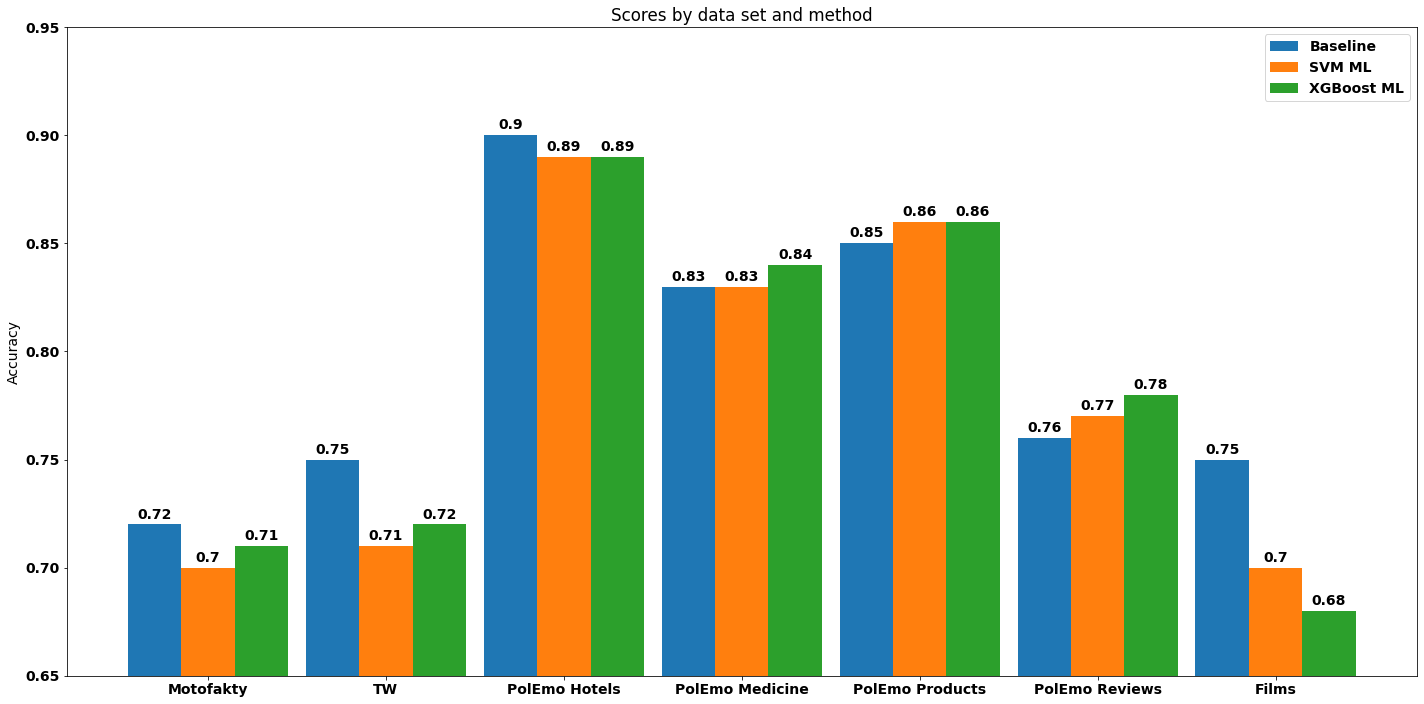

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
font = {'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)

labels = ['Motofakty', 'TW', 'PolEmo Hotels', 'PolEmo Medicine', 'PolEmo Products', 'PolEmo Reviews', 'Films']
baseline = [
        baseline_moto,
        baseline_tw,
        baseline_polemo_hotels,
        baseline_polemo_medicine,
        baseline_polemo_products,
        baseline_polemo_reviews,
        baseline_films 
]
metaSVM = [
          metaSVM_moto,
          metaSVM_tw,
          metaSVM_polemo_hotels,
          metaSVM_polemo_medicine,
          metaSVM_polemo_products,
          metaSVM_polemo_reviews,
          metaSVM_films
]
metaxgboost = [
              metaxgboost_moto,
              metaxgboost_tw,
              metaxgboost_polemo_hotels,
              metaxgboost_polemo_medicine,
              metaxgboost_polemo_products,
              metaxgboost_polemo_reviews,
              metaxgboost_films
]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars
fig, ax = plt.subplots(figsize=(20, 10))
plt.ylim(ymax = 0.95, ymin = 0.65)
rects1 = ax.bar(x - width, baseline, width, label='Baseline')
rects2 = ax.bar(x, metaSVM, width, label='SVM ML')
rects3 = ax.bar(x + width, metaxgboost, width, label='XGBoost ML')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Scores by data set and method')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

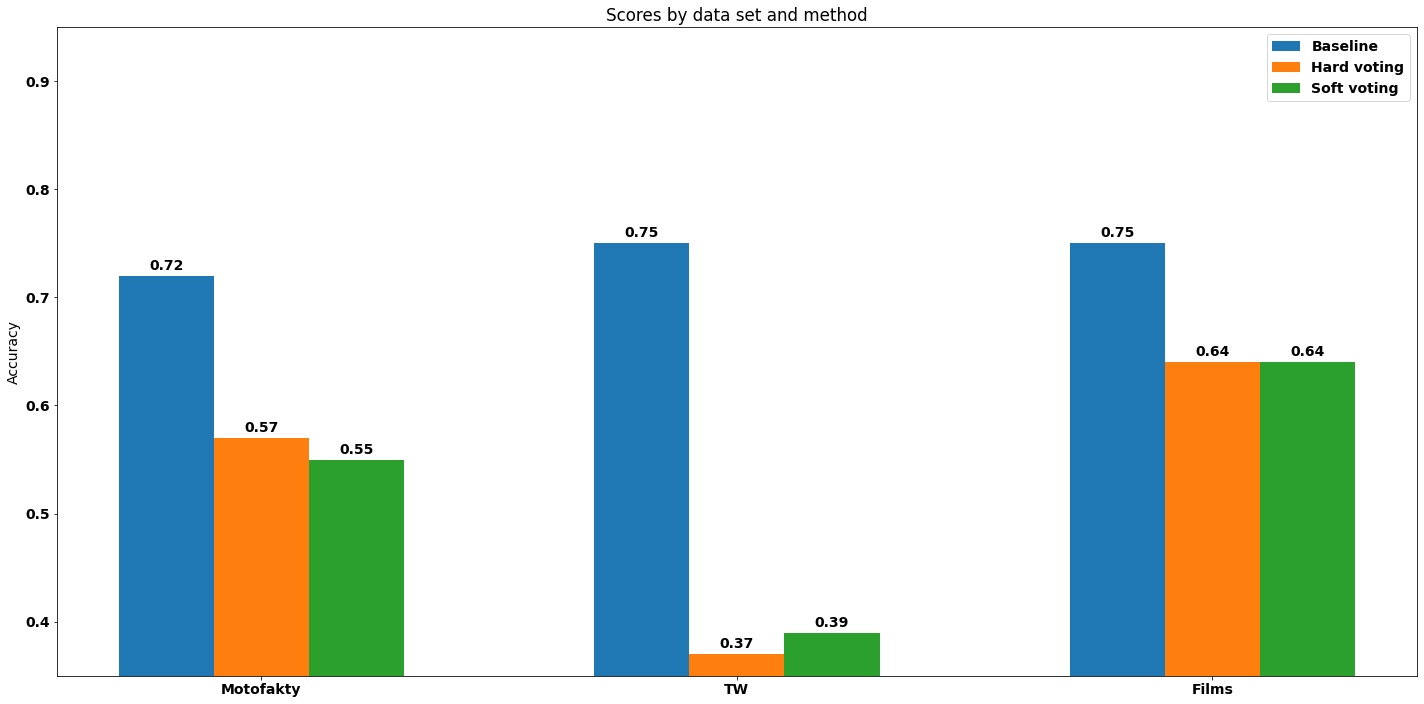

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
font = {'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)

labels = [
          'Motofakty', 'TW', 
          #'PolEmo Hotels', 'PolEmo Medicine', 'PolEmo Products', 'PolEmo Reviews', 
          'Films'
          ]
baseline = [
        baseline_moto,
        baseline_tw,
        #baseline_polemo_hotels,
        #baseline_polemo_medicine,
        #baseline_polemo_products,
        #baseline_polemo_reviews,
        baseline_films 
]
min = [
      #min_moto, 
      #min_tw, 
      min_polemo_hotels, 
      min_polemo_medicine,
      min_polemo_products, 
      min_polemo_reviews, 
      #min_films
]
max = [
      #max_moto,
      #max_tw,
      max_polemo_hotels,
      max_polemo_medicine,
      max_polemo_products,
      max_polemo_reviews,
      #max_films
]
median = [
        #median_moto,
        #median_tw,
        median_polemo_hotels, 
        median_polemo_medicine,
        median_polemo_products,
        median_polemo_reviews,
        #median_films 
]
hard_vote = [
            hard_vote_moto,
            hard_vote_tw,
            #hard_vote_polemo_hotels,
            #hard_vote_polemo_medicine,
            #hard_vote_polemo_products,
            #hard_vote_polemo_reviews,
            hard_vote_films
]
soft_vote = [
            soft_vote_moto,
            soft_vote_tw,
            #soft_vote_polemo_hotels,
            #soft_vote_polemo_medicine,
            #soft_vote_polemo_products,
            #soft_vote_polemo_reviews,
            soft_vote_films
]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
fig, ax = plt.subplots(figsize=(20, 10))
plt.ylim(ymax = 0.95, ymin = 0.35)
rects1 = ax.bar(x - width, baseline, width, label='Baseline')
rects2 = ax.bar(x, hard_vote, width, label='Hard voting')
rects3 = ax.bar(x + width, soft_vote, width, label='Soft voting')
#rects4 = ax.bar(x + 1.5*width, median, width, label='Median aggregation')
#rects5 = ax.bar(x + 1.5*width, hard_vote, width, label='Hard voting')
#rects6 = ax.bar(x + 3*width, soft_vote, width, label='Soft voting')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Scores by data set and method')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
#autolabel(rects4)
#autolabel(rects5)
#autolabel(rects6)

fig.tight_layout()

plt.show()

In [ ]:
from matplotlib import pyplot as plt


def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True, labels=None):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])
        
    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())
        ax.set_xticklabels(labels)

In [ ]:
baseline = [
        baseline_moto,
        baseline_tw,
        baseline_polemo_hotels,
        baseline_polemo_medicine,
        baseline_polemo_products,
        baseline_polemo_reviews,
        baseline_films 
]
metaSVM = [
          metaSVM_moto,
          metaSVM_tw,
          metaSVM_polemo_hotels,
          metaSVM_polemo_medicine,
          metaSVM_polemo_products,
          metaSVM_polemo_reviews,
          metaSVM_films
]
metaxgboost = [
              metaxgboost_moto,
              metaxgboost_tw,
              metaxgboost_polemo_hotels,
              metaxgboost_polemo_medicine,
              metaxgboost_polemo_products,
              metaxgboost_polemo_reviews,
              metaxgboost_films
]
min = [
      min_moto, 
      min_tw, 
      min_polemo_hotels, 
      min_medicine,
      min_products, 
      min_reviews, 
      min_films
]
max = [
      max_moto,
      max_tw,
      max_polemo_hotels,
      max_medicine,
      max_products,
      max_reviews,
      max_films
]
median = [
        median_moto,
        median_tw,
        median_polemo_hotels, 
        median_medicine,
        median_products,
        median_reviews,
        median_films 
]
hard_vote = [
            hard_vote_moto,
            hard_vote_tw,
            hard_vote_polemo_hotels,
            hard_vote_polemo_medicine,
            hard_vote_polemo_products,
            hard_vote_polemo_reviews,
            hard_vote_films
]
soft_vote = [
            soft_vote_moto,
            soft_vote_tw,
            soft_vote_polemo_hotels,
            soft_vote_polemo_medicine,
            soft_vote_polemo_products,
            soft_vote_polemo_reviews,
            soft_vote_films
]

In [ ]:
labels = ['Motofakty', 'TW', 'PolEmo Hotels', 'PolEmo Medicine', 'PolEmo Products', 'PolEmo Reviews', 'Films']

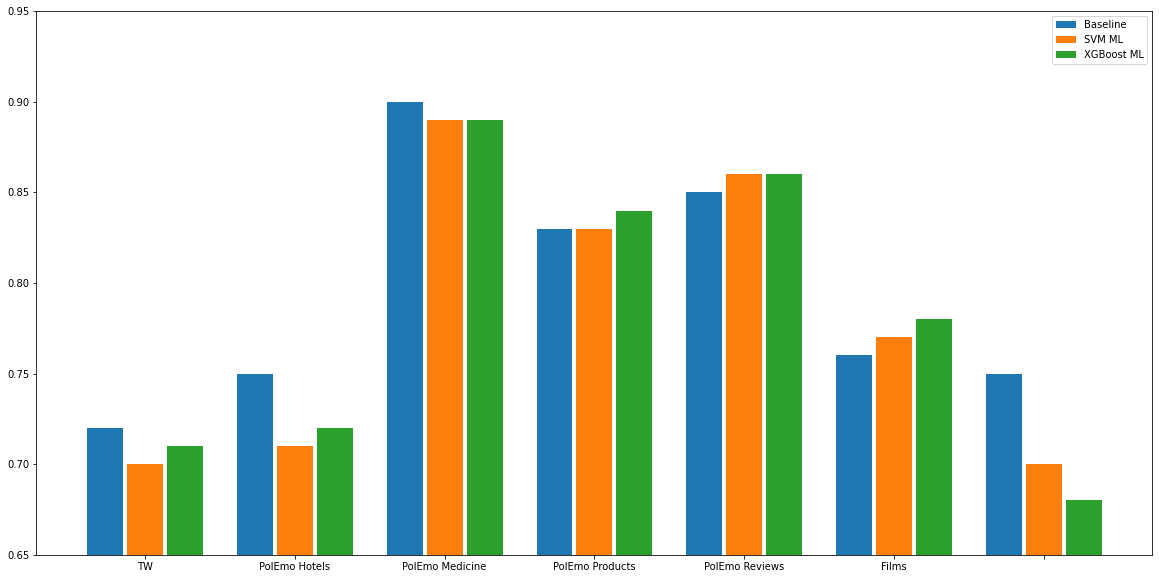

In [ ]:
data = {
        'Baseline': baseline, 
        'SVM ML': metaSVM,
        'XGBoost ML': metaxgboost,
        #'Min aggregation': min,
        #'Max aggregation': max,
        #'Median aggregation': median,
        #'Hard voting': hard_vote,
        #'Soft voting': soft_vote
    }

fig, ax = plt.subplots(figsize=(20, 10))
plt.ylim(ymax = 0.95, ymin = 0.65)
bar_plot(ax, data, total_width=.8, single_width=.9, labels = labels)
plt.show()